In [1]:
from dotenv import load_dotenv
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.documents import Document
from langchain_community.tools import DuckDuckGoSearchRun
from typing import TypedDict, Optional
from operator import itemgetter
import re
import os

In [2]:
load_dotenv()

# Initialize APIs
youtube = build('youtube', 'v3', developerKey=os.getenv("YOUTUBE_API_KEY"))
embedder = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)

In [3]:
class SearchResult:
    def __init__(self, search_result):
        self.video_id = search_result['id']['videoId']
        self.title = search_result['snippet']['title']
        self.transcript = self._get_transcript()

    def _get_transcript(self):
        try:
            transcript_list = YouTubeTranscriptApi.get_transcript(self.video_id)
            return " ".join([item['text'] for item in transcript_list])
        except Exception as e:
            print(f"Transcript error for {self.video_id}: {str(e)}")
            return ""

def search_yt(query, max_results=3):
    try:
        request = youtube.search().list(
            part="snippet",
            maxResults=max_results,
            q=query,
            videoCaption='closedCaption',
            type='video',
        )
        return request.execute().get('items', [])
    except Exception as e:
        print(f"YouTube API error: {str(e)}")
        return []

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

def create_faiss_index(items):
    documents = []
    for item in items:
        result = SearchResult(item)
        if not result.transcript:
            continue
            
        full_text = f"Title: {result.title}\nTranscript: {result.transcript}"
        chunks = text_splitter.split_text(full_text)
        
        for chunk in chunks:
            documents.append(Document(
                page_content=chunk,
                metadata={
                    "video_id": result.video_id,
                    "title": result.title
                }
            ))
    
    if not documents:
        print("No valid documents created")
        return None
    
    try:
        return FAISS.from_documents(documents, embedder)
    except Exception as e:
        print(f"FAISS error: {str(e)}")
        return None

In [4]:
class State(TypedDict, total=False):
    topic: str
    author: str
    question: str
    objective_check: Optional[bool]
    youtube_summary: str
    recent_fact_checks: str
    validate_yt_summary: str
    validate_fact_checks: Optional[bool]
    generate_summary: str

In [49]:
def get_user_input(state: State):
    # Simulate user input for the sake of this example

    topic = "Rich Dad Poor Dad",
    author = "Robert Kiyosaki",
    question = "is buying a house a good investment?",
    print(f"Topic: {topic}")
    print(f"Author: {author}")
    print(f"Question: {question}")
    return {
        "topic":topic,
        "author": author,
        "question": question,
        "objective_check": None,
        "youtube_summary": "",
        "recent_fact_checks": "",
        "validate_yt_summary": "",
        "validate_fact_checks": None,
        "generate_summary": ""
    }

In [5]:
def YouTube_search(state: State):
    try:
        print("\n=== Starting YouTube Search ===")
        
        # Step 1: Search YouTube
        items = search_yt(f"{state['topic']} {state['author']}")
        if not items:
            print("❌ No search results found")
            return state
        print("✅ Valid search results found")
        
        # Step 2: Create FAISS index
        faiss_index = create_faiss_index(items)
        if not faiss_index:
            print("❌ FAISS index creation failed")
            return state
        print("✅ FAISS index created successfully")
        
        # Step 3: Setup RAG chain
        template = """Analyze and respond as {author} would. Rules:
        1. Use ONLY provided context
        2. Maintain {author}'s style
        3. State "Need information" if context is insufficient
        
        Context: {context}
        Question: {question}
        {author}'s analysis:"""
        
        prompt = ChatPromptTemplate.from_template(template)
        
        rag_chain = (
            {"context": faiss_index.as_retriever(), 
             "question": RunnablePassthrough(),
             "author": lambda _: state["author"]}
            | prompt 
            | llm
            | StrOutputParser()
        )
        
        # Step 4: Generate summary
        state["youtube_summary"] = rag_chain.invoke(state["question"])
        print("✅ YouTube summary generated successfully")
        return state
        
    except Exception as e:
        print(f"\n❌ Critical search error: {str(e)}")
        return state

In [95]:
def validate_user_input(state: State):
    try:
        prompt = f"""Is this question relevant to {state['topic']}?
        Question: {state['question']}
        Respond ONLY 'True' or 'False'"""
        
        print(f"Validating user input... {state['question']} is relevant to {state['topic']}")
        
        response = llm.invoke(prompt).content.strip().lower()
        state["objective_check"] = response == "true"
        return state
    except Exception as e:
        print(f"Validation error: {str(e)}")
        state["objective_check"] = False
        return state

In [96]:
def validate_ytsummary(state: State):
    try:
        # Structured prompt with explicit formatting rules
        feedback_prompt = f"""ANALYSIS TASK:
        Verify if this YouTube summary adequately answers the user's question about {state['topic']} 
        in {state['author']}'s style. Use these strict criteria:

        [REQUIREMENTS]
        1. MUST directly address: "{state['question']}"
        2. MUST align with {state['author']}'s known perspectives
        3. MUST contain concrete information from the source

        [SUMMARY TO VALIDATE]
        {state['youtube_summary']}

        [RESPONSE FORMAT]
        - ONLY "VALID" if perfect
        - OR "SEARCH FOR CONTENT: [Topic Keywords] - {state['author']} - [Specific Aspect]"
        
        [EXAMPLE]
        SEARCH FOR CONTENT: wealth building strategies - Robert Kiyosaki - 2024 tax changes impact"""

        print("Validating YouTube summary...")
        print(f"Summary: {state['youtube_summary']}")
        print(f"Question: {state['question']}")
        
        response = llm.invoke(feedback_prompt).content.strip()
        
        # Strict response parsing
        if "SEARCH FOR CONTENT:" in response.upper():
            # Extract first matching pattern and clean special characters
            search_query = response.split("SEARCH FOR CONTENT:")[-1].split("\n")[0].strip()
            search_query = re.sub(r'[^a-zA-Z0-9\s\-:]', '', search_query)  # Remove special chars
            state["validate_yt_summary"] = f"SEARCH FOR CONTENT: {search_query}"
        else:
            state["validate_yt_summary"] = "VALID" if "VALID" in response.upper() else "SEARCH FOR CONTENT: general update - {state['author']} - current trends"

        return state
    
    except Exception as e:
        print(f"🔴 Validation error: {str(e)}")
        state["validate_yt_summary"] = f"SEARCH FOR CONTENT: {state['topic']} - {state['author']} - latest updates"
        return state

In [97]:
def fact_checks(state: State):
    try:
        print("\n=== Starting Fact Checks ===")
        
        # First check objective validation
        if not state.get("objective_check", True):
            state["recent_fact_checks"] = "Objective check failed, skipping fact checks."
            return state

        # Then check if search is needed
        if "SEARCH:" not in state["validate_yt_summary"].upper():
            return state

        # Proceed with search
        search_terms = state["validate_yt_summary"].split("SEARCH:")[-1].strip()
        search_query = f"{state['author']} {search_terms}"
        
        search = DuckDuckGoSearchRun()
        results = search.invoke(search_query)
        
        state["recent_fact_checks"] = results[:1000] if results else "No additional info found"
        return state

    except Exception as e:
        print(f"Fact check error: {str(e)}")
        state["recent_fact_checks"] = "Error in fact checking"
        return state


In [98]:
def validate_facts(state: State):
    try:
        prompt = f"""Does this contain valid information?
        {state['recent_fact_checks']}
        Respond 'True' or 'False'"""

        print("Validating fact checks...")
        
        response = llm.invoke(prompt).content.strip().lower()
        state["validate_fact_checks"] = response == "true"
        return state
    except Exception as e:
        print(f"Validation error: {str(e)}")
        state["validate_fact_checks"] = False
        return state

In [99]:
def consolidate_summary(state: State):
    try:
        print("Consolidating summary...")
        if not state["objective_check"]:
            state["generate_summary"] = "Question not relevant to the topic"
            return state
            
        if not state["validate_fact_checks"]:
            state["generate_summary"] = "Unable to verify information"
            return state

        prompt = f"""Combine these sources in {state['author']}'s style:
        YouTube: {state['youtube_summary']}
        Fact Checks: {state['recent_fact_checks']}
        
        Answer: {state['question']}"""
        
        state["generate_summary"] = llm.invoke(prompt).content
        return state
    except Exception as e:
        print(f"Summary error: {str(e)}")
        state["generate_summary"] = "Error generating summary"
        return state

In [100]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    print("\n=== Routing Input ===")

    if state["objective_check"] == True:
        print("Accepted in route_input")
        return "Accepted"
    elif state["objective_check"] == False:
        print("Rejected in route_input")
        return "Rejected"

In [102]:
def route_basedon_Summary(state: State):
    """Route based on summary validation status"""
    print("\n=== Routing Based on Summary ===")
    validate_status = state.get("validate_yt_summary", "").upper()

    if validate_status == "VALID":
        print("✅ Summary validated")
        return "Accepted"
    elif "SEARCH" in validate_status:
        print("🔍 Needs more information")
        return "need_more_info"
    else:
        print("❌ Invalid summary status")
        return "Rejected"


In [103]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [104]:
# Graph
Graphbuilder = StateGraph(State)
Graphbuilder.add_node("get_user_input", get_user_input)
Graphbuilder.add_node("YouTube_search",YouTube_search)
Graphbuilder.add_node("validate_user_input", validate_user_input)
Graphbuilder.add_node("validate_ytsummary", validate_ytsummary)
Graphbuilder.add_node("fact_checks", fact_checks)
Graphbuilder.add_node("consolidate_summary", consolidate_summary)
Graphbuilder.add_node("validate_facts", validate_facts)


Graphbuilder.add_edge(START, "get_user_input")
Graphbuilder.add_edge("get_user_input", "YouTube_search")
Graphbuilder.add_edge("YouTube_search", "validate_user_input")
Graphbuilder.add_edge("YouTube_search", "validate_ytsummary")
Graphbuilder.add_edge("fact_checks", "validate_facts")
Graphbuilder.add_edge("validate_facts", "consolidate_summary")
Graphbuilder.add_edge("consolidate_summary", END)


Graphbuilder.add_conditional_edges(
    "validate_user_input",
    route_input,
    {
        "Accepted": "fact_checks",
        "Rejected": "consolidate_summary"
    }
)


Graphbuilder.add_conditional_edges(
    "validate_ytsummary",
    route_basedon_Summary,
    {
        "Accepted": "fact_checks",
        "need more info": "fact_checks",
        "Rejected": "consolidate_summary"
    }
)


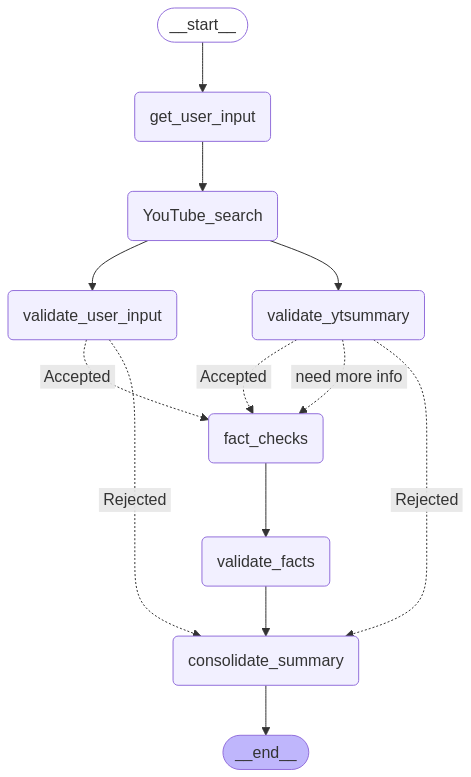

In [105]:
workflow = Graphbuilder.compile()
from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

In [109]:
def get_user_input(state: State) -> State:
    # Simulate user input for the sake of this example

    topic = "Rich Dad Poor Dad"
    author = "Robert Kiyosaki"
    question = "is buying a dog a investment?"
    print(f"Topic: {topic}")
    print(f"Author: {author}")
    print(f"Question: {question}")
    return {"topic": topic, "author": author, "question": question}

In [89]:
def get_user_input(state: State) -> State:
    # Simulate user input
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "is buying a house a good investment?",
        "objective_check": None,
        "youtube_summary": "",
        "recent_fact_checks": "",
        "validate_yt_summary": "",
        "validate_fact_checks": None,
        "generate_summary": ""
    }

In [113]:
workflow = Graphbuilder.compile()
state = get_user_input({})

Topic: Rich Dad Poor Dad
Author: Robert Kiyosaki
Question: is buying a dog a investment?


In [114]:
ggg = workflow.invoke(state)
print("Final State: ", ggg)


=== Starting YouTube Search ===
✅ Valid search results found
✅ FAISS index created successfully
✅ YouTube summary generated successfully
Validating user input... is buying a house a good investment? is relevant to Rich Dad Poor Dad
Validating YouTube summary...
Summary: Buying a house is not necessarily a good investment. Many people mistakenly believe that their house is an asset because it is a place where they live. However, the truth is that a house can actually be a liability if it is taking money out of your pocket rather than putting money in. This is because of expenses such as mortgage payments, taxes, and upkeep that constantly flow out of your pocket.

Instead of simply buying a house to live in, consider purchasing a property that can generate income for you. For example, when I was 25, I bought my first house, which was an apartment that I rented out. This investment property put money in my pocket rather than taking it out. The key is to focus on cash flow - assets put m

InvalidUpdateError: At key 'topic': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

In [92]:
if __name__ == "__main__":
    state = get_user_input({})
    state = YouTube_search(state)
    
    if state.get("youtube_summary"):
        state = validate_user_input(state)
        state = validate_ytsummary(state)
        state = fact_checks(state)
        state = validate_facts(state)
        state = consolidate_summary(state)
        
        print("\nFinal Results:")
        print(f"Topic: {state['topic']}")
        print(f"Question: {state['question']}")
        print(f"Relevance Check: {state['objective_check']}")
        print(f"Summary Validation: {state['validate_yt_summary']}")
        print(f"Author Analysis:\n{state['youtube_summary']}")
        print(f"Recent Fact Checks: {state['recent_fact_checks']}")
        print(f"Fact Check Validation: {state['validate_fact_checks']}")
        print(f"Generated Summary: {state['generate_summary']}")
    else:
        print("Processing failed - check error logs")


=== Starting YouTube Search ===
✅ Valid search results found
✅ FAISS index created successfully
✅ YouTube summary generated successfully
Validating user input... is buying a house a good investment? is relevant to Rich Dad Poor Dad
Validating YouTube summary...
Summary: Buying a house can be a good investment if it puts money in your pocket. However, for many people, their personal residence ends up being a liability because it takes money out of their pocket through expenses like mortgage payments, taxes, and upkeep. The key is to focus on cash flow - assets put money in your pocket, while liabilities take money out. It's important to consider whether a house will generate positive cash flow before deciding if it is a good investment. Look at where the cash is flowing and make sure it's flowing in the right direction. Financial intelligence is the ability to control cash flow, and that is what will ultimately determine if buying a house is a good investment for you.
Question: is buyi